# 6.5 Unsupervised Machine Learning: Clustering

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import numpy.linalg as nla
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import math
import six
import pylab as pl
import sklearn
from mlxtend.plotting import heatmap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances   # To calculate total within-cluster distance
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
# Changing the format of the values visualization

pd.options.display.float_format = '{:.2f}'.format

# Reseting the maximum number of columns to display to default (all columns)

pd.set_option('display.max_columns', None)

In [4]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.
%matplotlib inline

In [5]:
# Adjust setting to allow seeing all the rows in the output of this notebook
pd.options.display.max_rows = None

In [6]:
# Adjust setting to allow seeing all the columns in the output of this notebook
pd.options.display.max_columns = None

### Read Data

In [8]:
path = r'C:\Users\IVON6\Chocolate Bar Ratings Analysis'
df_chocolate_merged_clean = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'df_choco_merged_columns.csv'))

In [9]:
df_chocolate_merged_clean.head()

,Unnamed: 0,reference_number,company,company_location,review_date,bean_origin,bar_name,cocoa_percent,ingredients,taste,rating,num_ingredients,Cocoa_Percent_Range
0,0,999,Bahen & Co.,Australia,2012,Blend,Houseblend,70.00,"2- B,S","chalky, fragrant, then off",2.50,2.00,80-90%
1,1,999,Bahen & Co.,Australia,2012,Blend,Houseblend,70.00,"2- B,S","chalky, fragrant, then off",2.50,2.00,70-80%
2,2,999,Bahen & Co.,Australia,2012,Blend,Houseblend,70.00,"2- B,S","chalky, fragrant, then off",2.50,2.00,60-70%
3,3,999,Bahen & Co.,Australia,2012,Blend,Houseblend,70.00,"2- B,S","chalky, fragrant, then off",2.50,2.00,80-90%
4,4,999,Bahen & Co.,Australia,2012,Blend,Houseblend,70.00,"2- B,S","chalky, fragrant, then off",2.50,2.00,70-80%


In [10]:
#drop unnamed column

df_chocolate_merged_clean.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
#checking table size
df_chocolate_merged_clean.shape

(469023, 12)

In [12]:
df_chocolate_merged_clean.columns

Index(['reference_number', 'company', 'company_location', 'review_date',
       'bean_origin', 'bar_name', 'cocoa_percent', 'ingredients', 'taste',
       'rating', 'num_ingredients', 'Cocoa_Percent_Range'],
      dtype='object')

In [13]:
# Handle missing values

df_chocolate_merged_clean.ffill(inplace=True)

In [14]:
# Creating a separate dataframe to create correlations with numerical values only
df_clean_data_dub = df_chocolate_merged_clean[['company', 'bean_origin','company_location', 'reference_number', 'cocoa_percent', 'rating','review_date']].copy(deep=True)

In [15]:
df_clean_data_dub.dtypes

company              object
bean_origin          object
company_location     object
reference_number      int64
cocoa_percent       float64
rating              float64
review_date           int64
dtype: object

### Handling Categorical Columns

In [17]:
df_clean_data_analysis = df_clean_data_dub.copy
obj_cols = ['company','company_location','bean_origin']
df_clean_data_dub['company']= label_encoder.fit_transform(df_clean_data_dub['company'])
df_clean_data_dub['company_location']= label_encoder.fit_transform(df_clean_data_dub['company_location'])
df_clean_data_dub['bean_origin']= label_encoder.fit_transform(df_clean_data_dub['bean_origin'])

In [18]:
df_clean_data_dub.dtypes

company               int32
bean_origin           int32
company_location      int32
reference_number      int64
cocoa_percent       float64
rating              float64
review_date           int64
dtype: object

### Normalization Function

In [20]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [21]:
df_clean_data_dub.dtypes

company               int32
bean_origin           int32
company_location      int32
reference_number      int64
cocoa_percent       float64
rating              float64
review_date           int64
dtype: object

In [22]:
df_clean_data_normalize = normalize(df_clean_data_dub)
df_clean_data_normalize.head()

,company,bean_origin,company_location,reference_number,cocoa_percent,rating,review_date
0,0.06,0.05,0.01,0.35,0.48,0.50,0.35
1,0.06,0.05,0.01,0.35,0.48,0.50,0.35
2,0.06,0.05,0.01,0.35,0.48,0.50,0.35
3,0.06,0.05,0.01,0.35,0.48,0.50,0.35
4,0.06,0.05,0.01,0.35,0.48,0.50,0.35


### Standarization

In [24]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean_data_normalize)

In [25]:
scaled_data

array([[-1.4368448 , -1.83508827, -2.01407513, ..., -0.23566381,
        -1.43132215, -0.2955993 ],
       [-1.4368448 , -1.83508827, -2.01407513, ..., -0.23566381,
        -1.43132215, -0.2955993 ],
       [-1.4368448 , -1.83508827, -2.01407513, ..., -0.23566381,
        -1.43132215, -0.2955993 ],
       ...,
       [ 0.27877717,  0.68722012,  0.89292631, ...,  0.13253755,
        -0.29157408, -0.2955993 ],
       [ 0.27877717,  2.20060515,  0.89292631, ...,  0.13253755,
         0.27829995, -0.2955993 ],
       [ 0.27877717,  0.03862653,  0.89292631, ...,  0.13253755,
         0.27829995, -0.2955993 ]])

### Elbow Technique

In [27]:
# Define the range of potential clusters in the data.
k_range  = range(1, 10)

# Initialize an empty list to store WCSS values
wcss = []

for k in k_range: 
    # Define k-means clusters in the range assigned above.
    kmeans = KMeans(n_clusters = k, random_state=2)
    # Each k-means algorithm is applied onto data
    kmeans.fit(scaled_data)
    # We access the inertia_ attribute of the fitted KMeans object, which contains the WCSS value
    wcss.append(kmeans.inertia_)
    
wcss



[3283160.9999997853,
 2631177.658988369,
 2296076.776506462,
 2079280.2708148672,
 1908423.4367637362,
 1806289.9653615744,
 1689934.6079099462,
 1596275.7992523,
 1528992.3200481827]

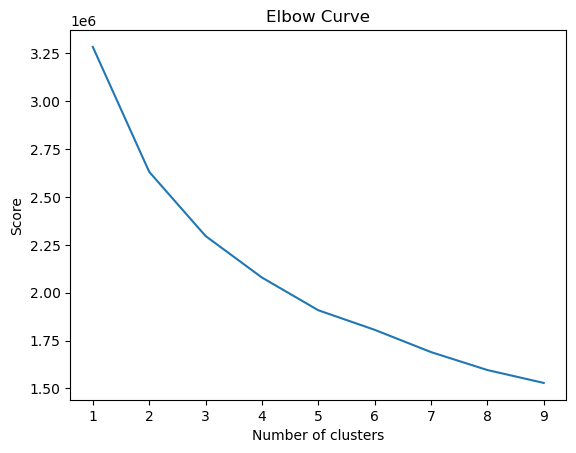

In [28]:
# Plot the scores to visualize the 'elbow'
pl.plot(k_range,wcss)
pl.title('Elbow Curve')
pl.xlabel('Number of clusters')
pl.ylabel('Score')
pl.show()

In [29]:
# I am having a hard time to determine where the curve begins to flatten out.
# From the elbow curve, it is inconclusive to determine the optimal number of clusters as there is no obvious elbow from the curve.

### Gap Statistic Method

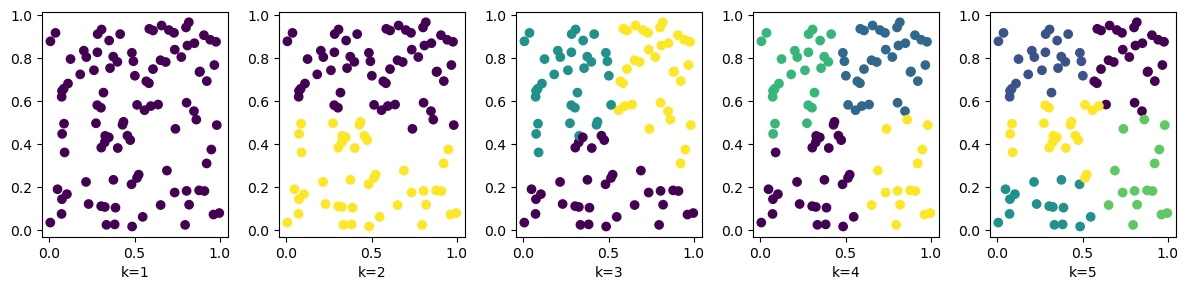

In [31]:
reference = np.random.rand(100, 2)
plt.figure(figsize=(12, 3))
for k in range(1,6):
    kmeans = KMeans(n_clusters=k)
    a = kmeans.fit_predict(reference)
    plt.subplot(1,5,k)
    plt.scatter(reference[:, 0], reference[:, 1], c=a)
    plt.xlabel('k='+str(k))
plt.tight_layout()
plt.show()

In [32]:
# From the figure above we can see that the algorithm evenly splits the points K clusters even if there's no separation between them. 
# Now I will try the same on a target dataset with 3 natural clusters:

### Create Clusters

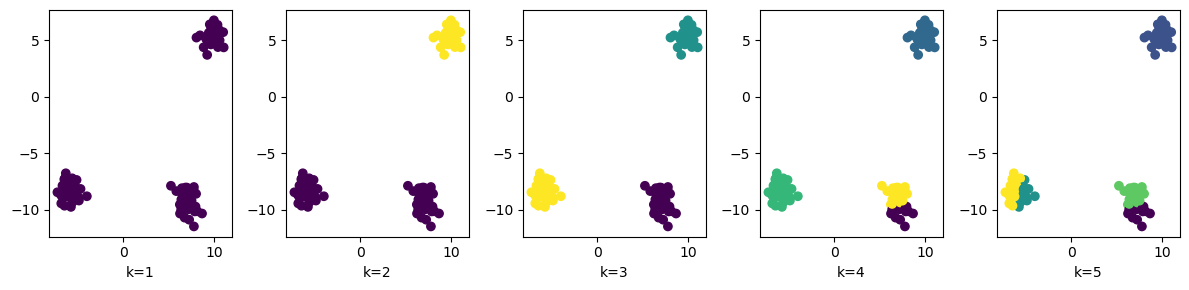

In [34]:
X = make_blobs(n_samples=100, n_features=2,
               centers=3, cluster_std=.8,)[0]

plt.figure(figsize=(12, 3))
for k in range(1,6):
    kmeans = KMeans(n_clusters=k)
    a = kmeans.fit_predict(X)
    plt.subplot(1,5,k)
    plt.scatter(X[:, 0], X[:, 1], c=a)
    plt.xlabel('k='+str(k))
plt.tight_layout()
plt.show()

In [35]:
# Here we note that the algorithm, with K=2, correctly isolates the two clusters. 
# Then, with K=3, K=4 and K=5 some of the natural clusters are split in two and three. 
# If we plot the inertia in both cases we'll see something interesting:

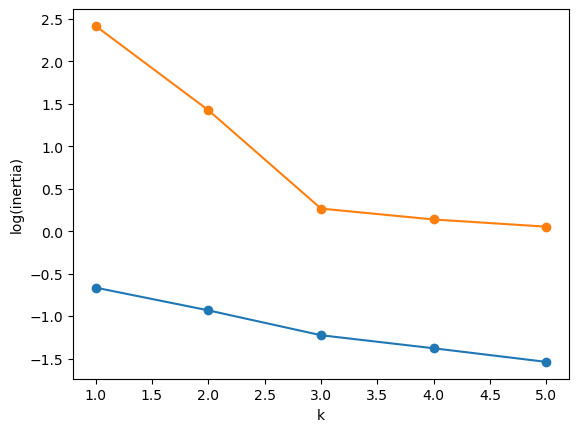

In [36]:
def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, scaled_data, k_max=5, n_references=5):
    if len(scaled_data.shape) == 1:
        scaled_data = scaled_data.reshape(-1, 1)
    reference = np.random.rand(*scaled_data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(scaled_data)
        ondata_inertia.append(compute_inertia(assignments, scaled_data))
        
    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 5
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(), X, k_max)


plt.plot(range(1, k_max+1), reference_inertia,
         '-o', label='reference')
plt.plot(range(1, k_max+1), ondata_inertia,
         '-o', label='scaled_data')
plt.xlabel('k')
plt.ylabel('log(inertia)')
plt.show()

In [37]:
# On the reference dataset the inertia goes down’ very slowly while on the target dataset it assumes the shape of an elbow! 
# We can now compute the Gap Statistics for each K computing the difference of the two curves showed above:

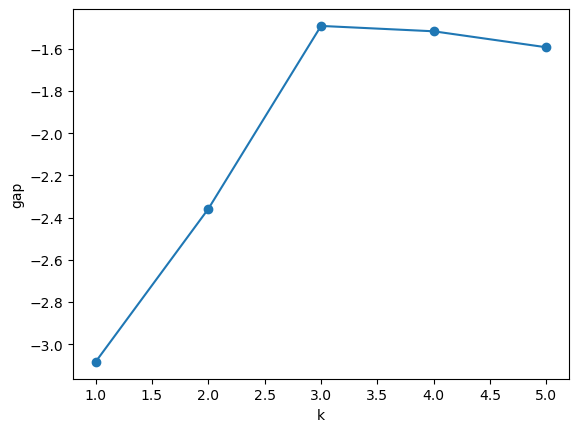

In [38]:
plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.show()

In [40]:
#It’s easy to see that the Gap is maximum for K=2, just the right choice for our target dataset

In [42]:
gap

array([-3.08340954, -2.35871031, -1.49217897, -1.51764885, -1.59344129])

In [44]:
k

5

## K-Means Clustering

In [47]:
# Create the k-means object with the optimal number of clusters.
kmeans = KMeans(n_clusters = 2)

In [49]:
# Fit the k-means object to the data.
kmeans.fit(scaled_data)

KMeans(n_clusters=2)

In [50]:
# Create a column in the dataframe with values corresponding to which cluster every observation belongs.
df_clean_data_normalize['clusters'] = kmeans.labels_

In [53]:
df_clean_data_normalize.head()

,company,bean_origin,company_location,reference_number,cocoa_percent,rating,review_date,clusters
0,0.06,0.05,0.01,0.35,0.48,0.50,0.35,0
1,0.06,0.05,0.01,0.35,0.48,0.50,0.35,0
2,0.06,0.05,0.01,0.35,0.48,0.50,0.35,0
3,0.06,0.05,0.01,0.35,0.48,0.50,0.35,0
4,0.06,0.05,0.01,0.35,0.48,0.50,0.35,0


In [55]:
df_clean_data_normalize['clusters'].value_counts(dropna = False)

clusters
1    258717
0    210306
Name: count, dtype: int64

### Visualizations and Basic Descriptive Statistics

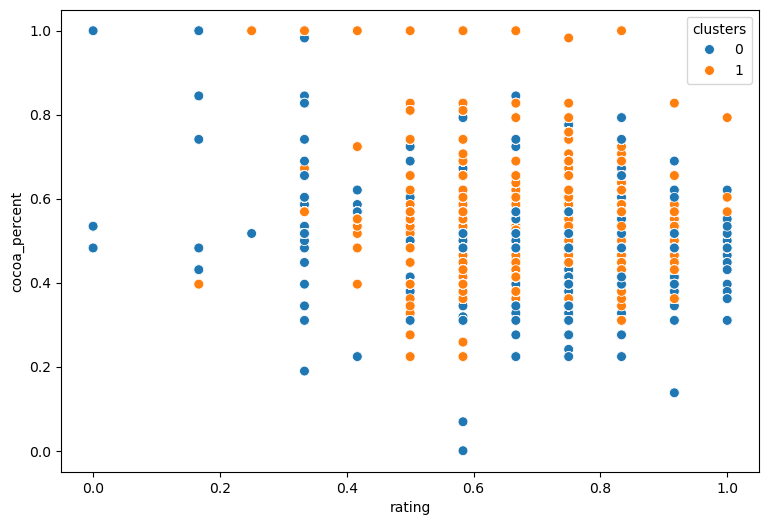

In [58]:
# Plot the clusters for the "rating" and "cocoa_percent" variables.

plt.figure(figsize = (9, 6))
ax = sns.scatterplot(x = df_clean_data_normalize['rating'], y = df_clean_data_normalize['cocoa_percent'], 
                     hue = df_clean_data_normalize['clusters'], s = 50) 
# 's' represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('rating') # Label x-axis.
plt.ylabel('cocoa_percent') # Label y-axis.
plt.show()

In [73]:
# Clusters tend to concentrate to the middle right side, this aligns with the conclusion of my hypothesis, rating does not affect cocoa_percent

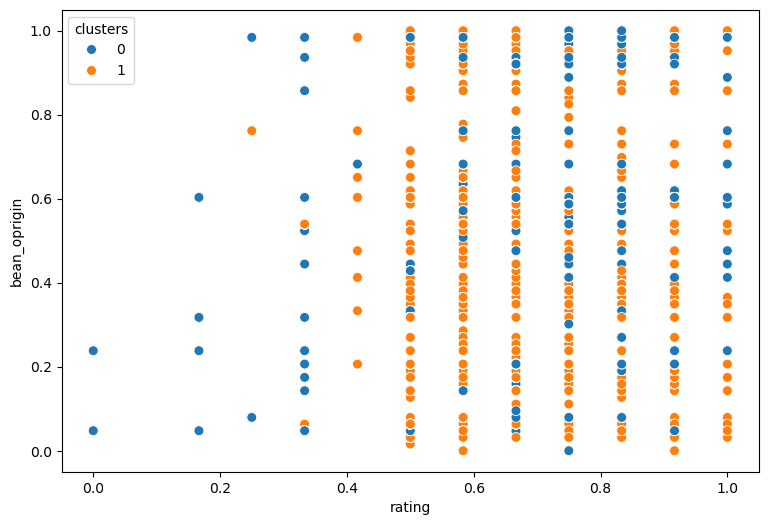

In [75]:
# Plot the clusters for the "rating" and "bean_origin" variables.

plt.figure(figsize = (9, 6))
ax = sns.scatterplot(x = df_clean_data_normalize['rating'], y = df_clean_data_normalize['bean_origin'], 
                     hue = df_clean_data_normalize['clusters'], s = 50) 
# 's' represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('rating') # Label x-axis.
plt.ylabel('bean_oprigin') # Label y-axis.
plt.show()

In [79]:
# Clusters tend to concentrate to the middle right side, I see more concentration of bean_origin than actually ratings, 
# this aligns with the conclusion the  rating does not affect bean_origin

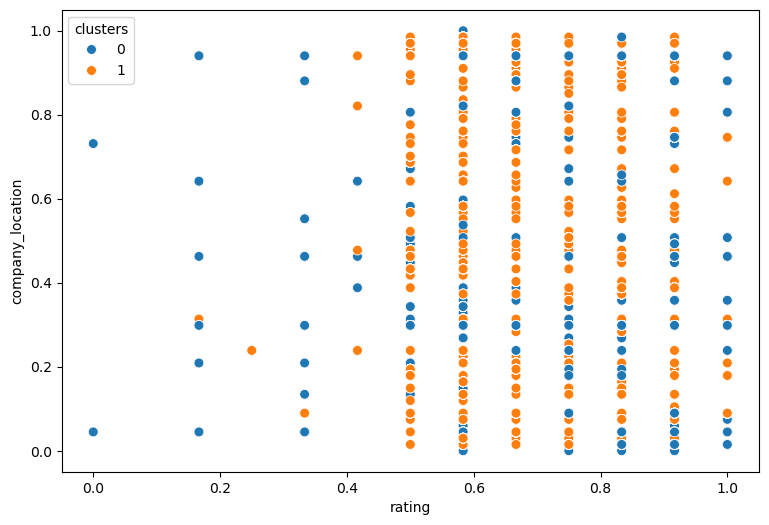

In [81]:
# Plot the clusters for the "rating" and "company_location" variables.

plt.figure(figsize = (9, 6))
ax = sns.scatterplot(x = df_clean_data_normalize['rating'], y = df_clean_data_normalize['company_location'], 
                     hue = df_clean_data_normalize['clusters'], s = 50) 
# 's' represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('rating') # Label x-axis.
plt.ylabel('company_location') # Label y-axis.
plt.show()

In [ ]:
# Clusters tend to concentrate to the middle right side. I can see a slight relation with the company location and ratings

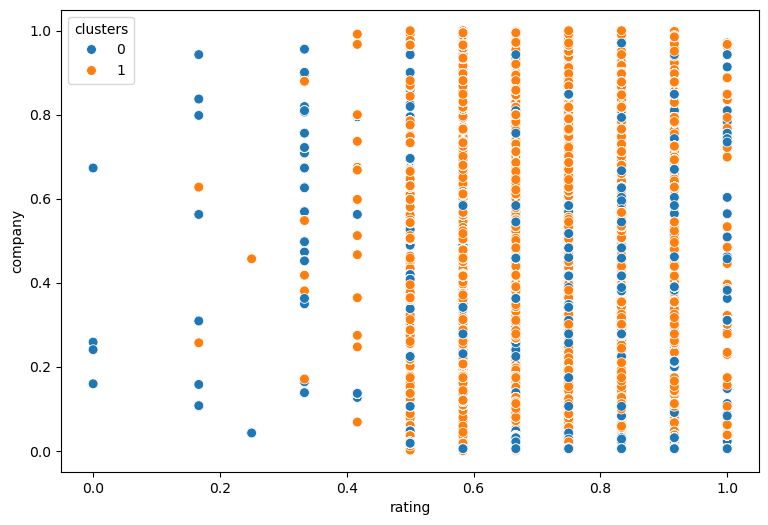

In [85]:
# Plot the clusters for the "rating" and "company" variables.

plt.figure(figsize = (9, 6))
ax = sns.scatterplot(x = df_clean_data_normalize['rating'], y = df_clean_data_normalize['company'], 
                     hue = df_clean_data_normalize['clusters'], s = 50) 
# 's' represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('rating') # Label x-axis.
plt.ylabel('company') # Label y-axis.
plt.show()

In [87]:
# this one is interesting because a litle more relation with the company and ratings.

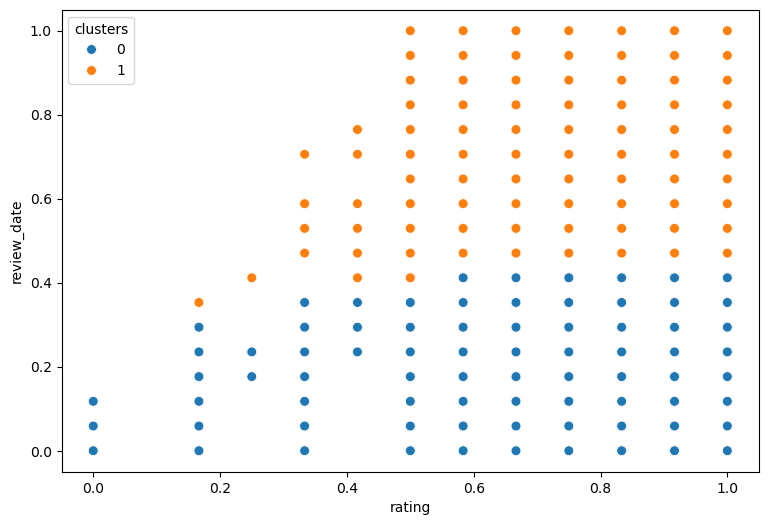

In [89]:
# Plot the clusters for the "rating" and "review_date" variables.

plt.figure(figsize = (9, 6))
ax = sns.scatterplot(x = df_clean_data_normalize['rating'], y = df_clean_data_normalize['review_date'], 
                     hue = df_clean_data_normalize['clusters'], s = 50) 
# 's' represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('rating') # Label x-axis.
plt.ylabel('review_date') # Label y-axis.
plt.show()

In [91]:
df_clean_data_normalize.loc[df_clean_data_normalize['clusters'] == 0, 'cluster'] = 'blue'
df_clean_data_normalize.loc[df_clean_data_normalize['clusters'] == 1, 'cluster'] = 'orange'

In [93]:
# Basic descriptive statistics for each cluster
df_clean_data_normalize.groupby('cluster').agg({'rating':['mean', 'median'], 
                                    'cocoa_percent':['mean', 'median'], 
                                    'bean_origin':['mean', 'median'],
                                    'company_location':['mean', 'median'],
                                    'company':['mean', 'median'],
                                    'review_date':['mean', 'median']})

rating        cocoa_percent        bean_origin         \
          mean median          mean median        mean median   
cluster                                                         
blue      0.73   0.75          0.50   0.48        0.48   0.48   
orange    0.69   0.67          0.51   0.48        0.43   0.48   

        company_location        company        review_date         
                    mean median    mean median        mean median  
cluster                                                            
blue                0.63   0.64    0.46   0.49        0.23   0.24  
orange              0.68   0.94    0.53   0.55        0.57   0.53

In [99]:
# In general there are not relations with cocoa_percent , bean_origin and ratings, 
#but I see more relation with the company and the company location VS ratings.